In [1]:
from functions.load_all_data import load_imgs_masks
from functions.sizes import compute_avg_size
from functions.composites import composite_masks
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt

# Load Images and Masks
* select a sample mask to experiment with
* rescale and resize each work equally well, simply accept different parameters
* rescale accepts a ratio, resize accepts a new shape
* NOTE: rescale ratio affects both height AND width, so giving a ratio of 0.5 returns a composite that is .25 as large

In [2]:
all_imgs, mask_colls = load_imgs_masks()[:2]

In [3]:
ex_imgs, ex_masks = all_imgs[:10], mask_colls[:10]

In [4]:
for i in range(len(ex_masks)):
    mask = ex_masks[i]
    ex_masks[i] = composite_masks(mask)

In [5]:
for img in ex_imgs[:2]:
    print(img.shape)

(256, 256, 4)
(520, 696, 4)


In [6]:
sample_img = ex_imgs[9]
sample_mask = ex_masks[9]

curr_size = compute_avg_size(sample_mask)
target_size = curr_size * 2

ratio = curr_size / target_size

In [7]:
rescaled = rescale(sample_mask, ratio, anti_aliasing=False, preserve_range=True, order=0)

0.5


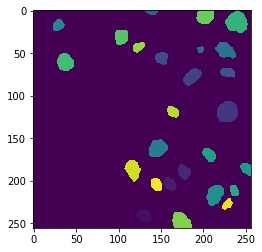

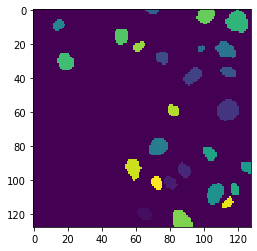

In [8]:
plt.imshow(sample_mask); plt.figure()
plt.imshow(rescaled)
print(ratio)

In [9]:
len(np.unique(rescaled))

27

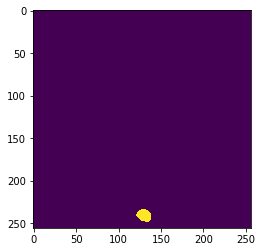

In [10]:
for color in np.unique(sample_mask):
    if color != 0:
        plt.imshow(sample_mask == color)
        break

# Experiment with decomposition for rescaling
* created technique for decomposing composite of masks
* each mask is rescaled individually and then the rescaled masks are made into a new composite
* both techniques (rescaling and decomposition) return desirable results

In [11]:
from functions.composites import decompose_composite
decomp_coll = decompose_composite(sample_mask)

In [12]:
new_shape = (sample_mask.shape[0] * ratio, sample_mask.shape[1] * ratio)
for i in range(len(decomp_coll)):
    mask = resize(decomp_coll[i], new_shape, anti_aliasing=False, preserve_range=True, order=0)
    decomp_coll[i] = mask

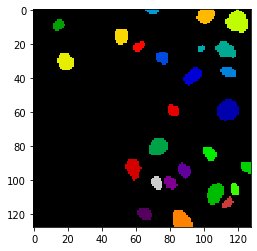

In [13]:
new_comp = composite_masks(decomp_coll)
plt.imshow(new_comp, cmap='nipy_spectral')

In [14]:
print("Original size = %f\nRescaled size = %f\nNew Comp. size = %f" 
     %(compute_avg_size(sample_mask), compute_avg_size(rescaled), compute_avg_size(new_comp)))

Original size = 236.038462
Rescaled size = 59.538462
New Comp. size = 59.538462


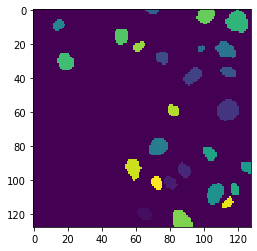

In [15]:
plt.imshow(rescaled)

In [16]:
assert int(compute_avg_size(sample_mask) * (ratio ** 2)) == int(compute_avg_size(new_comp))

# Confirm Numerically
* assert that rescaling works for different ratios and mask compositions

In [ ]:
for i in range(670):
    curr_mask = composite_masks(mask_colls[i])
    curr_size = compute_avg_size(curr_mask)
    
    rand_val = np.random.uniform() * 3
    rand_target = int(curr_size * rand_val)
    rand_ratio = rand_target / curr_size
    rand_ratio = rand_ratio ** (1/2) % 5
    
    rand_target = int(curr_size * (rand_ratio ** 2))
    rand_shape = (int(curr_mask.shape[0] * rand_ratio),
                  int(curr_mask.shape[1] * rand_ratio))
    
    resized_mask = resize(curr_mask, rand_shape, anti_aliasing=False, preserve_range=True, order=0)
    resized_size = compute_avg_size(resized_mask)
    diff = abs(int(rand_target - resized_size))
    
    if rand_target > 1000:
        error = curr_size * .1
    else:
        error = 20
        
    assert diff <= error, "Mask: %d, Ratio: %f, Difference: %f\n\t\tOriginal size: %f Target size: %f, Rescaled size: %f" %(i, rand_ratio, diff, curr_size, rand_target, resized_size)

print("All good!")

# Rescale Images

In [ ]:
resized_img = resize(all_imgs[200], 
                      (all_imgs[200].shape[0] * ratio, 
                       all_imgs[200].shape[1] * ratio),
                      anti_aliasing=True, preserve_range=False)
plt.imshow(all_imgs[200]); plt.figure()
plt.imshow(resized_img)

In [ ]:
from functions.rescaling import rescale_composite

In [ ]:
rescaled_img, rescaled_comp = rescale_composite(sample_img, sample_mask, 800, True)